In [20]:
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib.dates as mdates
from matplotlib.gridspec import GridSpec, GridSpecFromSubplotSpec
import seaborn as sb
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import mean_squared_error, r2_score

In [4]:
import warnings

# Suppressing specific warning
warnings.filterwarnings("ignore", category=FutureWarning)

# Suppressing all warnings
warnings.filterwarnings("ignore")

# DATA LOADING

In [5]:
file_path_client= r"Data\client.csv"
client_data= pd.read_csv(file_path_client)

In [6]:
file_path_electricity_prices= r"Data/electricity_prices.csv"
electricity_prices= pd.read_csv (file_path_electricity_prices)

In [7]:
file_path_forecast_weather= r"Data\forecast_weather.csv"
forecast_weather= pd.read_csv (file_path_forecast_weather)

In [8]:
file_path_gas_prices= r"Data\gas_prices.csv"
gas_prices= pd.read_csv (file_path_gas_prices)

In [9]:
file_path_historical_weather= r"Data\historical_weather.csv"
historical_weather= pd.read_csv (file_path_historical_weather)

In [10]:
file_path_train= r"Data\train.csv"
train= pd.read_csv (file_path_train)

In [11]:
file_path_weather_station_to_county_mapping= r"Data\weather_station_to_county_mapping.csv"
weather_station_to_county_mapping= pd.read_csv (file_path_weather_station_to_county_mapping)

# COMBINING NECESSARY DATASETS

In [12]:
# Ensure date columns are in datetime format
client_data['date'] = pd.to_datetime(client_data['date'])
gas_prices['origin_date'] = pd.to_datetime(gas_prices['origin_date'])
electricity_prices['origin_date'] = pd.to_datetime(electricity_prices['origin_date'])

# Display the first few rows of the dataframes to inspect the date columns
print("Client DataFrame:")
print(client_data.head())
print("Gas Prices DataFrame:")
print(gas_prices.head())
print("Electricity Prices DataFrame:")
print(electricity_prices.head())

# Merge client and train data
combined_df = pd.merge(client_data, train, on=['county', 'is_business', 'product_type', 'data_block_id'], how='inner')
print("After merging client and train data:")
print(combined_df.columns)

# Display the first few rows to inspect the merge result
print(combined_df.head())

# Merge with electricity prices data
combined_df = pd.merge(combined_df, electricity_prices, left_on=['data_block_id', 'date'], right_on=['data_block_id', 'origin_date'], how='left', suffixes=('', '_electricity'))
print("After merging with electricity prices data:")
print(combined_df.columns)

# Check if the 'origin_date_electricity' column exists
if 'origin_date_electricity' in combined_df.columns:
    combined_df.drop(columns=['origin_date_electricity'], inplace=True)
else:
    print("Column 'origin_date_electricity' not found.")

# Display the first few rows to inspect the merge result
print(combined_df.head())

# Merge with gas prices data
combined_df = pd.merge(combined_df, gas_prices, left_on=['data_block_id', 'date'], right_on=['data_block_id', 'origin_date'], how='left', suffixes=('', '_gas'))
print("After merging with gas prices data:")
print(combined_df.columns)

# Check if the 'origin_date_gas' column exists
if 'origin_date_gas' in combined_df.columns:
    combined_df.drop(columns=['origin_date_gas'], inplace=True)
else:
    print("Column 'origin_date_gas' not found.")

# Display the first few rows to inspect the merge result
print(combined_df.head())

# Save the combined data to a new CSV file
combined_df.to_csv('combined_data.csv', index=False)

print("Data combined successfully.")

Client DataFrame:
   product_type  county  eic_count  installed_capacity  is_business  \
0             1       0        108              952.89            0   
1             2       0         17              166.40            0   
2             3       0        688             7207.88            0   
3             0       0          5              400.00            1   
4             1       0         43             1411.00            1   

        date  data_block_id  
0 2021-09-01              2  
1 2021-09-01              2  
2 2021-09-01              2  
3 2021-09-01              2  
4 2021-09-01              2  
Gas Prices DataFrame:
  forecast_date  lowest_price_per_mwh  highest_price_per_mwh origin_date  \
0    2021-09-01                 45.23                  46.32  2021-08-31   
1    2021-09-02                 45.62                  46.29  2021-09-01   
2    2021-09-03                 45.85                  46.40  2021-09-02   
3    2021-09-04                 46.30            

# MODEL COMPARING

After performing extensive model building and comparing them in individual notebooks, we can summarize our findings as shown below:

The following comparison is for the above combination of datasets (gas proces, electricity prices, client data and train data.)

In [18]:
rmse_table = pd.DataFrame(columns=['Model', 'RMSE'])

# Define a function to add a model's results to the table
def add_rmse_values(model_name, rmse):
    global rmse_table
    new_row = pd.DataFrame({'Model': [model_name], 'RMSE': [rmse]})
    rmse_table = pd.concat([rmse_table, new_row], ignore_index=True)

# Adding models' RMSE values manually
add_rmse_values('Linear Regression', 831.756)
add_rmse_values('Auto Regression', 905.652)
add_rmse_values('Random Forest', 666.104)
add_rmse_values('SARIMA', 750.456)

# Save the table to a CSV file
rmse_table.to_csv('rmse_values.csv', index=False)

# Display the table
print(rmse_table)

               Model     RMSE
0  Linear Regression  831.756
1    Auto Regression  905.652
2      Random Forest  666.104
3             SARIMA  750.456


It is clear to us that Random Forest model gives us the best result.

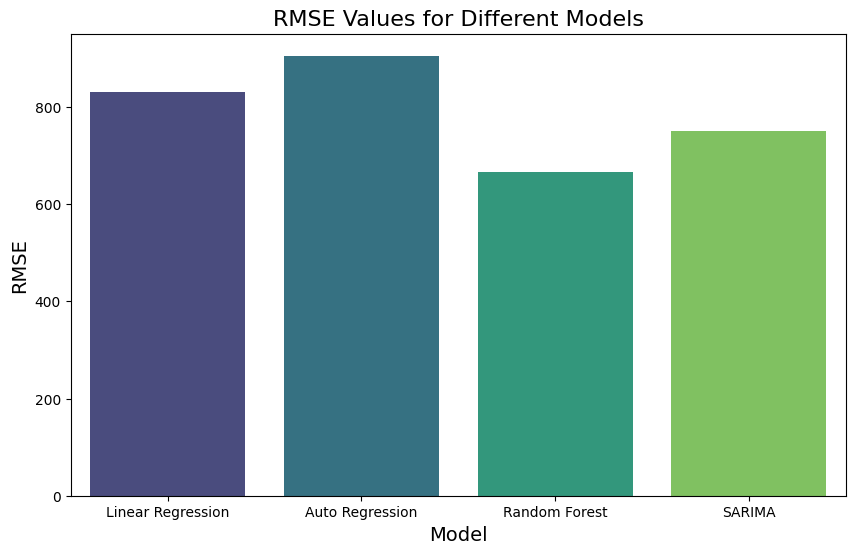

In [19]:
# Creating a bar plot
plt.figure(figsize=(10, 6))
sb.barplot(x='Model', y='RMSE', data=rmse_table, palette='viridis')

# Adding title and labels
plt.title('RMSE Values for Different Models', fontsize=16)
plt.xlabel('Model', fontsize=14)
plt.ylabel('RMSE', fontsize=14)

plt.show()

If we try to combine train data with forecst weather data, the Random Forest model has the following difference in RMSE and R^2 values (Here, Dataset 1 is the combination of client, electricity prices, gas prices and train dataset and Dataset 2 is the combination of forecast weather and train dataset.) :

From this comparison, we get that even though the RMSE value of Dataset 2 is slightly better that that of Dataset 1, the R^2 value of Dataset 2 is negative. 

From the comparison performed below, we can conclude that the Random Forest model for the combination of client, electricity prices, gas prices and train dataset give the best results.

     Dataset     RMSE     R²
0  Dataset 1  666.104  0.442
1  Dataset 2  639.234 -0.016


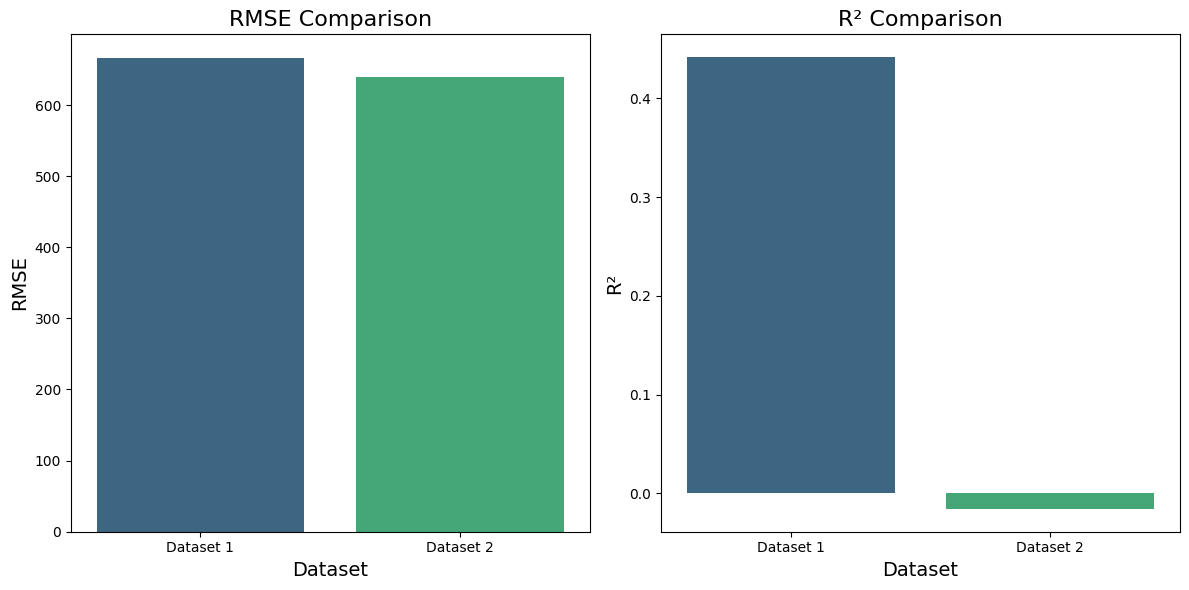

In [28]:
metrics_comparison = pd.DataFrame(columns=['Dataset', 'RMSE', 'R²'])

# Define a function to add metrics values for a dataset
def add_metrics_values(dataset_name, rmse, r2):
    global metrics_comparison
    new_row = pd.DataFrame({'Dataset': [dataset_name], 'RMSE': [rmse], 'R²': [r2]})
    metrics_comparison = pd.concat([metrics_comparison, new_row], ignore_index=True)

# Adding metrics values manually for Dataset 1 and Dataset 2
add_metrics_values('Dataset 1', 666.104, 0.442)
add_metrics_values('Dataset 2', 639.234, -0.016)

# Display the table
print(metrics_comparison)

# Create a bar plot for RMSE
plt.figure(figsize=(12, 6))
plt.subplot(1, 2, 1)
sb.barplot(x='Dataset', y='RMSE', data=metrics_comparison, palette='viridis')
plt.title('RMSE Comparison', fontsize=16)
plt.xlabel('Dataset', fontsize=14)
plt.ylabel('RMSE', fontsize=14)

# Create a bar plot for R²
plt.subplot(1, 2, 2)
sb.barplot(x='Dataset', y='R²', data=metrics_comparison, palette='viridis')
plt.title('R² Comparison', fontsize=16)
plt.xlabel('Dataset', fontsize=14)
plt.ylabel('R²', fontsize=14)

# Add legend
legend_labels = {
    'Dataset 1': 'Dataset 1: Combination of client, train, electricity and gas',
    'Dataset 2': 'Dataset 2: Combination of train and forecast weather'
}

# Adjust layout
plt.tight_layout()

# Show the plot
plt.show()

# MODEL FINALIZING:

The code below elaborates on the results.

In [23]:
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import mean_squared_error, r2_score

# Define the main determining columns and the target variable
main_columns = ['is_business', 'county', 'product_type'] 
target_column = 'target'

# Remove rows with missing values in the target variable
combined_df = combined_df.dropna(subset=[target_column])

# Remove rows with missing values in the main determining columns
combined_df = combined_df.dropna(subset=main_columns)

# Split the dataset into features and target variable
X = combined_df[main_columns]
y = combined_df[target_column]

# Debugging step to check for any remaining NaNs
print(f'Number of NaNs in target variable y: {y.isna().sum()}')
print(f'Number of NaNs in feature variables X:\n{X.isna().sum()}')

# Ensure no NaNs remain in the data
if y.isna().sum() > 0 or X.isna().sum().sum() > 0:
    raise ValueError("There are still NaNs in the data after attempting to drop them.")

# Split the dataset into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Debugging step to check the shapes of training and testing sets
print(f'Shape of X_train: {X_train.shape}')
print(f'Shape of X_test: {X_test.shape}')
print(f'Shape of y_train: {y_train.shape}')
print(f'Shape of y_test: {y_test.shape}')

# Standardize the features
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

# Random Forest
rf_model_dif = RandomForestRegressor(n_estimators=100, random_state=42)
rf_model_dif.fit(X_train_scaled, y_train)
y_pred_rf_dif = rf_model_dif.predict(X_test_scaled)
mse_rf_dif = mean_squared_error(y_test, y_pred_rf_dif)
r2_rf_dif = r2_score(y_test, y_pred_rf_dif)

print(f'Mean Squared Error RF: {mse_rf_dif}')
print(f'R^2 Score RF: {r2_rf_dif}')

Number of NaNs in target variable y: 0
Number of NaNs in feature variables X:
is_business     0
county          0
product_type    0
dtype: int64
Shape of X_train: (1607347, 3)
Shape of X_test: (401837, 3)
Shape of y_train: (1607347,)
Shape of y_test: (401837,)
Mean Squared Error RF: 456988.88938118675
R^2 Score RF: 0.44283358691348906


In [24]:
# Define the features and the target variable
features = ['county', 'is_business', 'product_type', 'data_block_id']
target = 'target'

# Encode categorical variables
combined_df_encoded = pd.get_dummies(combined_df[features], drop_first=True)

# Ensure the target variable is included
combined_df_encoded[target] = combined_df[target]

# Split the data into train and test sets
X = combined_df_encoded.drop(columns=[target])
y = combined_df_encoded[target]

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Initialize the Random Forest Regressor
rf = RandomForestRegressor(random_state=42)

# Train the model
rf.fit(X_train, y_train)

# Make predictions
y_pred_train = rf.predict(X_train)
y_pred_test = rf.predict(X_test)

# Calculate the R² and RMSE for the training set
r2_train = r2_score(y_train, y_pred_train)
rmse_train = np.sqrt(mean_squared_error(y_train, y_pred_train))

# Calculate the R² and RMSE for the test set
r2_test = r2_score(y_test, y_pred_test)
rmse_test = np.sqrt(mean_squared_error(y_test, y_pred_test))

# Print the results
print(f"Training R²: {r2_train:.4f}")
print(f"Training RMSE: {rmse_train:.4f}")
print(f"Test R²: {r2_test:.4f}")
print(f"Test RMSE: {rmse_test:.4f}")

Training R²: 0.4782
Training RMSE: 658.7664
Test R²: 0.4471
Test RMSE: 673.4416


In [29]:
target_range = 15480  # Maximum target value
normalized_rmse_train = (rmse_train / target_range) * 100
normalized_rmse_test = (rmse_test / target_range) * 100

print(f"Normalized Training RMSE: {normalized_rmse_train:.2f}%")
print(f"Normalized Test RMSE: {normalized_rmse_test:.2f}%")

Normalized Training RMSE: 4.26%
Normalized Test RMSE: 4.35%


# CONCLUSION
1) Moderate Fit: The R² values suggest that the model explains a moderate portion of the variance in the target variable.
2) Reasonable Error: The normalized RMSE values (around 4.25% - 4.35%) indicate that the errors are reasonable relative to the range of the target values.
3) Potential for Improvement: Although the model performs moderately well, there is room for improvement.

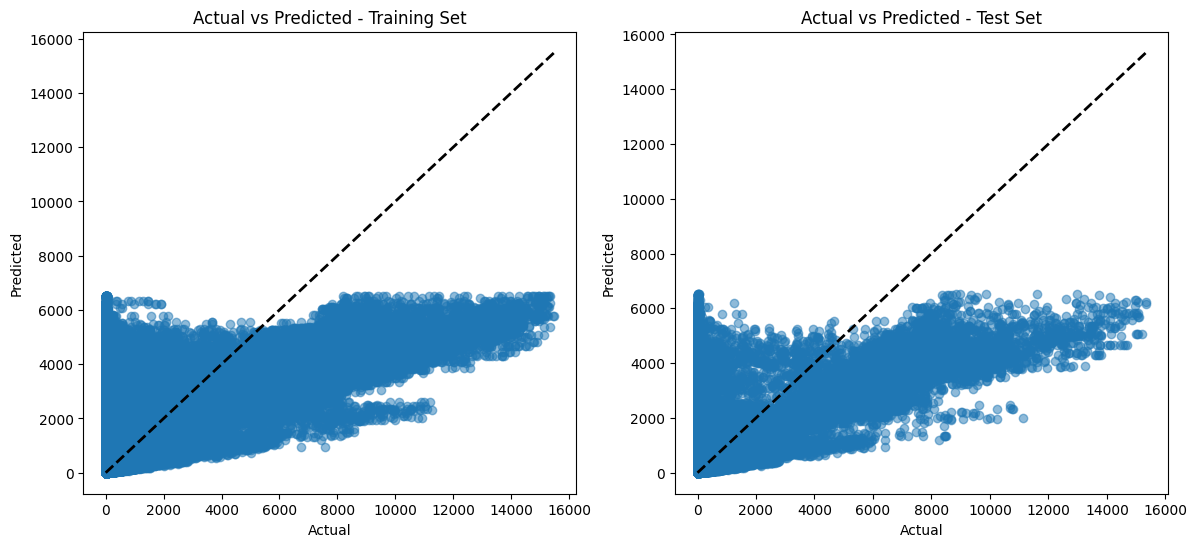

In [30]:
# Plot actual vs predicted values for training set
plt.figure(figsize=(14, 6))

# Training set
plt.subplot(1, 2, 1)
plt.scatter(y_train, y_pred_train, alpha=0.5)
plt.plot([y_train.min(), y_train.max()], [y_train.min(), y_train.max()], 'k--', lw=2)
plt.xlabel('Actual')
plt.ylabel('Predicted')
plt.title('Actual vs Predicted - Training Set')

# Test set
plt.subplot(1, 2, 2)
plt.scatter(y_test, y_pred_test, alpha=0.5)
plt.plot([y_test.min(), y_test.max()], [y_test.min(), y_test.max()], 'k--', lw=2)
plt.xlabel('Actual')
plt.ylabel('Predicted')
plt.title('Actual vs Predicted - Test Set')

plt.show()